In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.options.mode.chained_assignment = None

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_2018.csv')

C:\Users\dsgeb\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (42,167,168,169,170,179,180,183,184,189,190,191,192,199,200,201,202,203,204,205,206,208,210,212,227,228,229,230,231,232,233,234,235,237,238,239,241,242,250) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#Get rid of quarters ending and other events
data = data.loc[
    (data['epa'].notnull()) &
    ((data['play_type'] == 'no_play') |
    (data['play_type'] == 'pass') |
    (data['play_type'] == 'run'))
]

#Remove timeouts
data.drop(data[(data['replay_or_challenge'] == 0) & (data['desc'].str.contains('Timeout'))].index, inplace=True)

#Classify running plays with penalities as runs
data.loc[data.desc.str.contains('left end|left tackle|left guard|up the middle|right guard|right tackle|right end|rushes'), 'play_type'] = 'run'

#Classify scrambles, sacks, and incomplete/complete with penalty as pass plays instead of runs/no play
data.loc[data.desc.str.contains('scrambles|sacked|pass'), 'play_type'] = 'pass'

#Remove kneels and spikes
#Kneels and spikes with penalties are classified as no_play, thus not removed in above cell
data = data.loc[data.desc.str.contains('kneels|spiked') == False]

#Reindex data dataframe
data.reset_index(drop=True, inplace=True)

In [5]:
#Create a smaller dataframe with plays where rusher_player_name is null
rusher_nan = data.loc[(data['play_type'] == 'run') &
         (data['rusher_player_name'].isnull())]

#Create a list of the indexes/indices for the plays where rusher_player_name is null
rusher_nan_indices = list(rusher_nan.index)

for i in rusher_nan_indices:
    #Split the description on the blank spaces, isolating each word
    desc = data['desc'].iloc[i].split()
    
    #For each word in the play description
    for j in range(0,len(desc)):
        #If a word is right, up, or left
        if desc[j] == 'right' or desc[j] == 'up' or desc[j] == 'left':
            #Set rusher_player_name for that play to the word just before the direction
            data['rusher_player_name'].iloc[i] = desc[j-1]
            
        else:
            pass

In [6]:
passer_nan = data.loc[(data['play_type'] == 'pass') &
         (data['passer_player_name'].isnull())]

passer_nan_indices = list(passer_nan.index)

for i in passer_nan_indices:
    desc = data['desc'].iloc[i].split()
    
    for j in range(0,len(desc)):
        if desc[j] == 'pass':
            data['passer_player_name'].iloc[i] = desc[j-1]
            
        else:
            pass
        
data.loc[data['passer_player_name'] == 'Backward', 'passer_player_name'] = float('NaN')

In [7]:
data.insert(69, 'success', 0)
data.loc[data['epa'] > 0, 'success'] = 1

In [8]:
game_info = pd.read_csv('https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/games_data/regular_season/reg_games_2018.csv')

In [9]:
pass_epa = []
rush_epa = []

for i in range(1,18):
    game_ids = game_info['game_id'].loc[game_info['week'] == i].values
    
    plays = data.loc[data['game_id'].isin(game_ids)]
    
    pass_epa.append(plays['epa'].loc[plays['play_type']=='pass'].mean())
    rush_epa.append(plays['epa'].loc[plays['play_type']=='run'].mean())

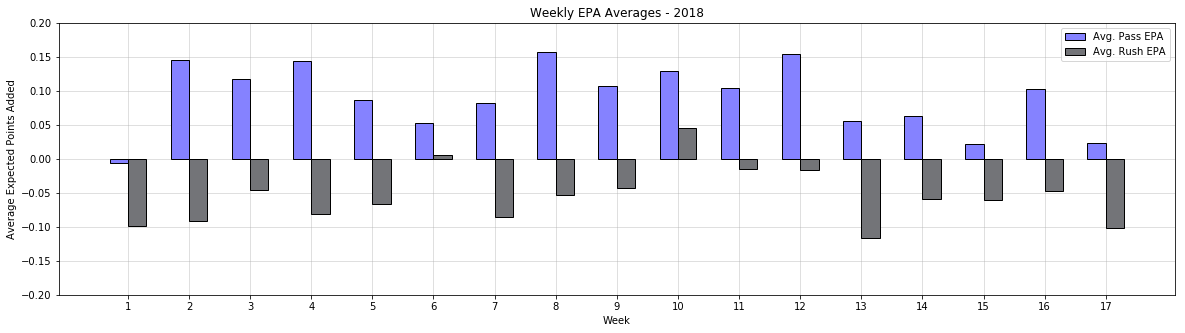

In [10]:
x_loc = np.arange(1,18)
width=.3

fig, ax = plt.subplots(figsize=(20,5))
rects1=ax.bar(x_loc-width/2,pass_epa, width=.3, label='Avg. Pass EPA', color='#8582ff', edgecolor='black')
rects2=ax.bar(x_loc+width/2,rush_epa, width=.3, label='Avg. Rush EPA', color='#737478', edgecolor='black')

ax.set_xticks(x_loc)
ax.set_yticks([-.2,-.15,-.1,-.05,0,.05,.10,.15,.20])
ax.set_xlabel('Week')
ax.set_ylabel('Average Expected Points Added')
ax.set_title('Weekly EPA Averages - 2018')
ax.grid(alpha=.5)
ax.set_axisbelow(True)
ax.legend()

plt.savefig('average_weekly_epa.png', dpi=600)

In [11]:
neutral_pass_epa = []
neutral_rush_epa = []

for i in range(1,18):
    game_ids = game_info['game_id'].loc[game_info['week'] == i].values
    
    plays = data.loc[(data['game_id'].isin(game_ids)) & (data['qtr'] <= 2) & (data['down'] <= 2)]
    
    neutral_pass_epa.append(plays['epa'].loc[plays['play_type']=='pass'].mean())
    neutral_rush_epa.append(plays['epa'].loc[plays['play_type']=='run'].mean())

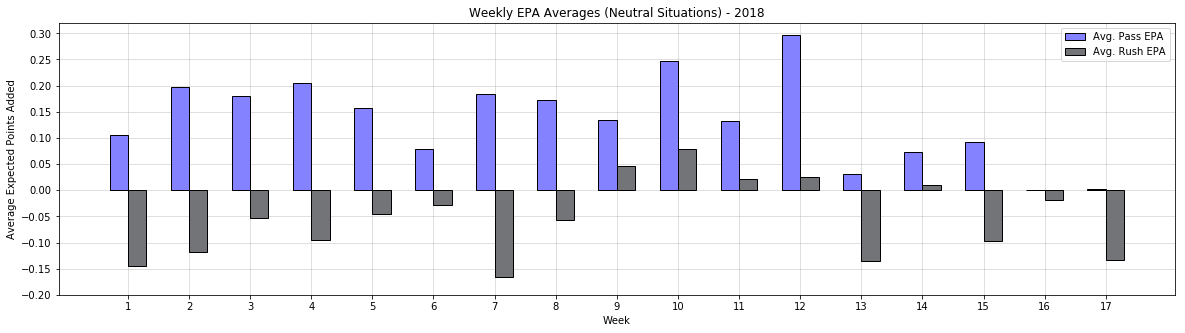

In [12]:
x_loc = np.arange(1,18)
width=.3

fig, ax = plt.subplots(figsize=(20,5))
rects1=ax.bar(x_loc-width/2,neutral_pass_epa, width=.3, label='Avg. Pass EPA', color='#8582ff', edgecolor='black')
rects2=ax.bar(x_loc+width/2,neutral_rush_epa, width=.3, label='Avg. Rush EPA', color='#737478', edgecolor='black')

ax.set_xticks(x_loc)
ax.set_yticks([-.2,-.15,-.1,-.05,0,.05,.10,.15,.20,.25,.3])
ax.set_xlabel('Week')
ax.set_ylabel('Average Expected Points Added')
ax.set_title('Weekly EPA Averages (Neutral Situations) - 2018')
ax.grid(alpha=.5)
ax.set_axisbelow(True)
ax.legend()

plt.savefig('average_weekly_epa_neutral.png', dpi=600)